NAME : ANAI SUNNY    STUDENT ID : SUN23618219

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:17<00:00, 188MB/s]
100% 2.29G/2.29G [00:17<00:00, 139MB/s]


In [ ]:
# Import necessary libraries for deep learning, data manipulation, and evaluation
import os
import numpy as np
from PIL import Image
from typing import Tuple, List, Optional
from tqdm import tqdm
from sklearn.model_selection import train_test_split# For splitting dataset into training and testing sets
import torch  # For PyTorch deep learning framework
import torch
import torch.optim as optim # For optimization algorithms
import torch.nn as nn
from torchvision.models import vgg16 # Pretrained VGG16 model from torchvision
import matplotlib.pyplot as plt

In [ ]:
import zipfile

# Unzip the dataset
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# List the extracted files to confirm
import os
os.listdir('/content/')

['.config', 'chest-xray-pneumonia.zip', 'chest_xray', 'sample_data']

In [ ]:
def load_data(
    base_dir: str,  # Base directory containing image datasets
    target_size: Tuple[int, int] = (224, 224),
    max_normal_images: Optional[int] = None,
    max_pneumonia_images: Optional[int] = None
) -> Tuple[np.ndarray, np.ndarray]:
    images: List[np.ndarray] = []
    labels: List[int] = []  # List to store corresponding labels (0 or 1)

    normal_count = 0
    pneumonia_count = 0

    for subdir, _, files in os.walk(base_dir):  # Traverse directories and files
        if "NORMAL" in subdir:
            label = 0
        elif "PNEUMONIA" in subdir:
            label = 1
        else:
            continue

        for file in tqdm(files, desc=f"Loading {os.path.basename(subdir)}"):
            if file.endswith(('.jpeg', '.jpg', '.png')):
                img_path = os.path.join(subdir, file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)

                    # Control the number of images to load
                    if label == 0 and max_normal_images and normal_count >= max_normal_images:  # Increment counter for normal images
                        continue
                    if label == 1 and max_pneumonia_images and pneumonia_count >= max_pneumonia_images:
                        continue

                    images.append(np.array(img))
                    labels.append(label)

                    if label == 0:
                        normal_count += 1
                    else:
                        pneumonia_count += 1
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)

Loading PNEUMONIA: 100%|██████████| 3876/3876 [01:14<00:00, 51.73it/s]


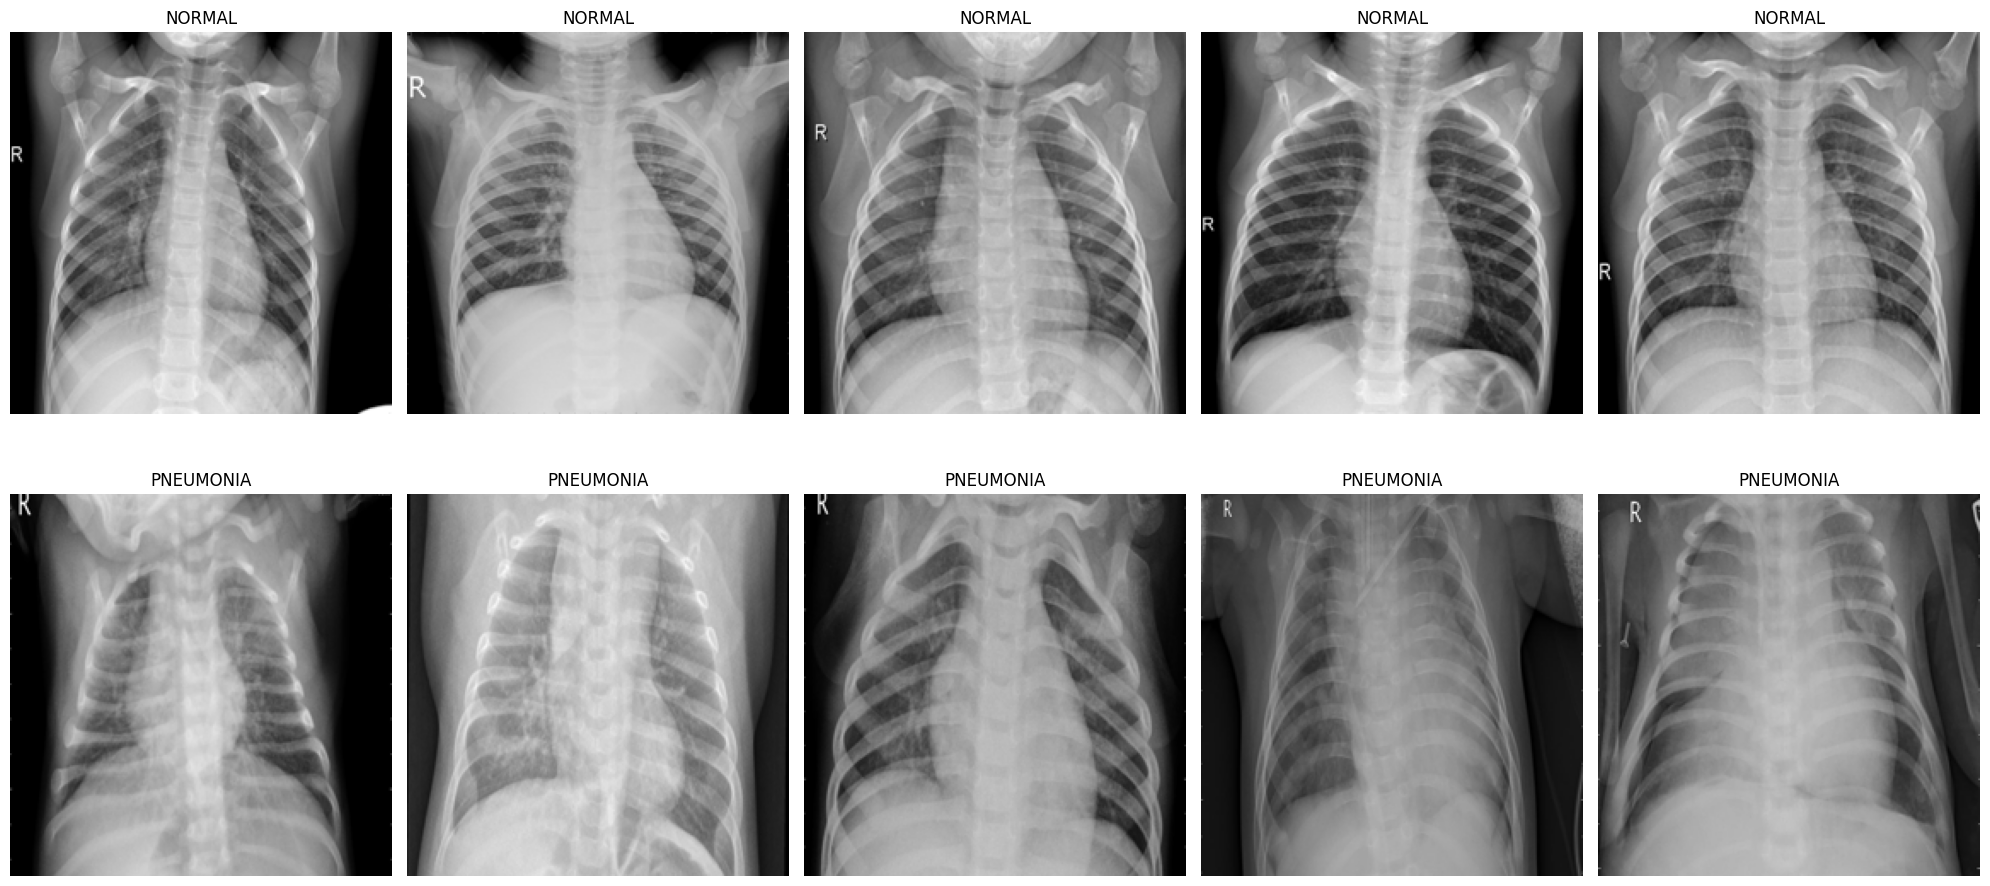

In [ ]:
import matplotlib.pyplot as plt


def plot_sample_images(images, labels, num_samples_per_class=5):  # Split images by their labels: 0 for normal and 1 for pneumonia

    normal_images = images[labels == 0]
    pneumonia_images = images[labels == 1]

     # Set the number of images to display (limit by num_samples_per_class)

    num_normal = min(len(normal_images), num_samples_per_class)
    num_pneumonia = min(len(pneumonia_images), num_samples_per_class)

    plt.figure(figsize=(20, 10))

    for i in range(num_normal):
        plt.subplot(2, num_samples_per_class, i + 1)
        plt.imshow(normal_images[i])
        plt.axis('off')
        plt.title("NORMAL")

    for i in range(num_pneumonia):
        plt.subplot(2, num_samples_per_class, num_samples_per_class + i + 1)
        plt.imshow(pneumonia_images[i])
        plt.axis('off')
        plt.title("PNEUMONIA")

    plt.tight_layout()
    plt.show()

    # Load dataset (images and labels)

base_dir = '/content/chest_xray/chest_xray/train'  # Assuming this is your data directory
images, labels = load_data(base_dir, max_normal_images=700, max_pneumonia_images=700)


plot_sample_images(images, labels, num_samples_per_class=5)

del images, labels

In [ ]:
def initialize_model():
    model = vgg16(pretrained=True)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 1)  # 1 output for binary classification
    return model

In [ ]:
def train_client(model, x_train, y_train, epochs, batch_size):
    model.train()
    device = next(model.parameters()).device  # Get the device (CPU or GPU) the model is on
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCEWithLogitsLoss() # Binary Cross-Entropy loss with logits (for binary classification)
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    total_loss = 0.0
     # Loop through epochs
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to the appropriate device (GPU/CPU)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
             # Return the trained model's state_dict (weights) and average loss over all batches

    return model.state_dict(), total_loss / len(dataloader)

In [ ]:
def federated_averaging(client_weights):
    global_weights = client_weights[0]
    for key in global_weights.keys():
        global_weights[key] = torch.stack([weights[key] for weights in client_weights], dim=0).mean(dim=0)
    return global_weights

def validate_global_model(model, x_val, y_val):
    model.eval()
    device = next(model.parameters()).device
    loss_fn = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        x_val, y_val = x_val.to(device), y_val.to(device)
        outputs = model(x_val).squeeze()
        predictions = torch.sigmoid(outputs) > 0.5
        correct = (predictions == y_val).sum().item()
        accuracy = correct / len(y_val) * 100
        loss = loss_fn(outputs, y_val.float())
    return loss.item(), accuracy

# Federated learning
def federated_learning(clients_data, global_model, epochs, rounds, batch_size, validation_data):
    x_val, y_val = validation_data
    for round_num in range(rounds):
        print(f"\n### Federated Learning Round {round_num + 1}/{rounds} ###")
        client_weights = []
        for client_id, (x_train, y_train) in enumerate(clients_data):
            print(f"Training on client {client_id + 1}/{len(clients_data)}")
            local_model = initialize_model()
            local_model.load_state_dict(global_model.state_dict())
            local_model.to(next(global_model.parameters()).device)
            client_weight, _ = train_client(local_model, x_train, y_train, epochs, batch_size)
            client_weights.append(client_weight)
        global_weights = federated_averaging(client_weights)
        global_model.load_state_dict(global_weights)
        val_loss, val_accuracy = validate_global_model(global_model, x_val, y_val)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

In [ ]:
base_dir = '/content/chest_xray/chest_xray/train'
images, labels = load_data(base_dir, max_normal_images=700, max_pneumonia_images=700)

# Normalize images and split data
images = images / 255.0  # Normalize to [0, 1]
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, train_size=0.8, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

Loading PNEUMONIA: 100%|██████████| 3876/3876 [01:12<00:00, 53.23it/s]


In [ ]:
x_train, y_train = torch.tensor(x_train).permute(0, 3, 1, 2).float(), torch.tensor(y_train).float()
x_val, y_val = torch.tensor(x_val).permute(0, 3, 1, 2).float(), torch.tensor(y_val).float()
x_test, y_test = torch.tensor(x_test).permute(0, 3, 1, 2).float(), torch.tensor(y_test).float()

In [ ]:
num_clients = 3
client_data_size = len(x_train) // num_clients
clients_data = [
    (x_train[i * client_data_size:(i + 1) * client_data_size],
     y_train[i * client_data_size:(i + 1) * client_data_size])
    for i in range(num_clients)
]

**Model Architecture**
The deep learning model used is based on the VGG16 architecture.

Convolutional Layers:

Multiple convolutional layers that extract spatial features at different levels of abstraction.

Pooling Layers:

Max-pooling layers reduce the spatial dimensions of feature maps, retaining essential features while decreasing computational complexity.

Fully Connected Layers:

A series of dense layers at the end, which transform the extracted features into class probabilities.

Activation Functions:

ReLU in intermediate layers to speed up convergence and mitigate the vanishing gradient problem.

Hyperparameters
Learning Rate: 1e-4 (Adam optimizer) - Chosen for a stable yet responsive training process.
Loss Function: BCEWithLogitsLoss - Combines a sigmoid activation with binary cross-entropy loss, making it ideal for binary classification.
Batch Size: 16 - Balances memory usage and gradient update frequency.
Epochs: 2 per client, with 5 federated rounds - Designed for quick experimentation in this simulation.

VGG16 as a Baseline:

VGG16 is a proven architecture for image classification tasks, particularly medical imaging.
The pretrained VGG16 weights (on ImageNet) accelerate convergence by leveraging learned features.

Federated Learning Setup:The model structure supports easy integration into federated learning, where local updates are aggregated into global improvements.
Binary Classification Task:

The architecture and loss function are optimized for detecting two classes (Normal vs. Pneumonia).





In [ ]:

# Initialize global model and device
global_model = initialize_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)

# Train with federated learning
federated_learning(
    clients_data=clients_data,
    global_model=global_model,
    epochs=2,
    rounds=3,
    batch_size=16,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.2MB/s]



### Federated Learning Round 1/5 ###
Training on client 1/3
Training on client 2/3
Training on client 3/3
Validation Loss: 0.1404, Validation Accuracy: 95.00%

### Federated Learning Round 2/5 ###
Training on client 1/3


In [ ]:
import torch
from torchvision.transforms import transforms
from PIL import Image

def preprocess_image(image_path: str, target_size: Tuple[int, int] = (224, 224)) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)

def predict(model: torch.nn.Module, image_path: str, device: torch.device) -> str:
    model.eval()
    image = preprocess_image(image_path).to(device)

    with torch.no_grad():
        output = model(image).squeeze()
        probability = torch.sigmoid(output).item()
        prediction = "Pneumonia" if probability > 0.5 else "Normal"

    print(f"Image: {image_path} | Predicted: {prediction} | Probability: {probability:.4f}")
    return prediction

# Example usage
image_path = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)

predict(global_model, image_path, device)

In [ ]:

# Save the trained model
torch.save(global_model, 'pneumonia_detection_model.pth')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

# Dummy Dataset (Replace with your dataset)
X_train = torch.rand(100, 10)  # Example training data
y_train = torch.randint(0, 2, (100,))  # Example binary labels
X_test = torch.rand(20, 10)  # Example test data
y_test = torch.randint(0, 2, (20,))  # Example binary labels

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Model Definition
class SimpleModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.fc(x)

# Initialize Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = SimpleModel(input_size=10, num_classes=2).to(device)  # Adjust input size and num_classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trained_model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    trained_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = trained_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete!")

# Testing Function
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds))

# Test the Model
print("Starting model testing...")
test_model(trained_model, test_loader, device=device)
